<a href="https://colab.research.google.com/github/Fauzi2202/CapstoneProject-MuhammadFauzi/blob/main/CapstoneProject_MuhammadFauzi_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 0) Instalasi dependensi
!pip -q install --upgrade langchain langchain-community replicate google-api-python-client pandas matplotlib tqdm python-dotenv


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 750.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
google-colab 1.0.0 require

In [ ]:
# 1) Setup API Key & Parameter
import os, getpass
from dotenv import load_dotenv
from google.colab import userdata

load_dotenv()
api_token = userdata.get('api_token')
REPLICATE_API_TOKEN = api_token
YOUTUBE_API_KEY = os.getenv("YOUTUBE_API_KEY") or getpass.getpass("Masukkan API Key YouTube: ")

# Ganti sesuai model Granite Instruct pilihan Anda di Replicate:
REPLICATE_MODEL = os.getenv("REPLICATE_MODEL", "ibm-granite/granite-3.3-8b-instruct")

# Parameter
MAX_COMMENTS = 1000   # batasi jumlah komentar
TEMPERATURE = 0.0
MAX_NEW_TOKENS = 64
BATCH_SLEEP = 0.3    # jeda antar request (hindari rate limit)

os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN
assert REPLICATE_API_TOKEN and YOUTUBE_API_KEY, "API key tidak boleh kosong"

Masukkan API Key YouTube: ··········


In [ ]:
# 2) Import Library & Helper
import re, time
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from googleapiclient.discovery import build
from langchain_community.llms import Replicate

plt.rcParams.update({"figure.figsize": (6,4)})

def clean_text(text: str) -> str:
    text = text or ""
    text = text.strip().lower()
    text = re.sub(r"http\S+", "", text)             # hapus URL
    text = re.sub(r"@[\w_]+", "", text)             # hapus mention
    text = re.sub(r"#[\w_]+", "", text)             # hapus hashtag
    text = re.sub(r"\s+", " ", text)                # normalisasi spasi
    return text

def force_label(s: str):
    s = (s or "").strip().lower()
    if "pos" in s: return "Positif"
    if "neg" in s: return "Negatif"
    if "net" in s or "neutral" in s: return "Netral"
    return "Netral"


In [ ]:
# 3) Ambil Komentar YouTube
YOUTUBE_VIDEO_ID = "Mj5Ll1KZyuM"  # <== ISI dengan Video ID"
assert YOUTUBE_VIDEO_ID, "Isi YOUTUBE_VIDEO_ID terlebih dahulu."

def fetch_youtube_comments(video_id: str, api_key: str, max_comments: int = 1000):
    youtube = build("youtube", "v3", developerKey=api_key)
    comments = []
    next_page = None
    while True:
        req = youtube.commentThreads().list(
            part="snippet",
            videoId=video_id,
            maxResults=100,
            pageToken=next_page,
            textFormat="plainText"
        )
        resp = req.execute()
        for item in resp.get("items", []):
            top = item["snippet"]["topLevelComment"]["snippet"]
            comments.append({
                "author": top.get("authorDisplayName"),
                "publishedAt": top.get("publishedAt"),
                "likeCount": top.get("likeCount"),
                "text": top.get("textDisplay", "")
            })
            if len(comments) >= max_comments:
                return comments
        next_page = resp.get("nextPageToken")
        if not next_page:
            break
    return comments

raw_comments = fetch_youtube_comments(YOUTUBE_VIDEO_ID, YOUTUBE_API_KEY, MAX_COMMENTS)
df = pd.DataFrame(raw_comments)
df["clean_text"] = df["text"].apply(clean_text)
df.head()

,author,publishedAt,likeCount,text,clean_text
0,@WidWod1112,2025-04-01T12:45:04Z,261,ada yang sampe buka jasa generate foto ghibli ...,ada yang sampe buka jasa generate foto ghibli ...
1,@faramika_rizki,2025-07-14T18:27:11Z,0,"Yuukk,, mari kita kembali aja ke jaman Wartel....","yuukk,, mari kita kembali aja ke jaman wartel...."
2,@kana_7079,2025-04-27T11:08:27Z,0,Buat nge prompt AI tetep butuh literasi yang b...,buat nge prompt ai tetep butuh literasi yang b...
3,@Osucarus,2025-04-24T06:09:40Z,0,"AI itu hanyalah alat, penggunanya yang menentukan","ai itu hanyalah alat, penggunanya yang menentukan"
4,@e-n456,2025-04-20T12:03:09Z,0,Eno bening ghibli,eno bening ghibli


In [ ]:
df.to_csv("youtube_sentiment.csv", index=False)

In [ ]:
from google.colab import files
files.download("youtube_sentiment.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 4) Load LLM (Replicate + IBM Granite Instruct)
llm = Replicate(
    model=REPLICATE_MODEL,
    model_kwargs={
        "temperature": TEMPERATURE,
        "max_new_tokens": MAX_NEW_TOKENS,
    },
)

SENTIMENT_PROMPT = (
    """
Anda adalah asisten analisis sentimen.
Tugas Anda adalah mengklasifikasikan komentar berikut ke dalam salah satu kategori:
- POSITIF → jika komentar mengandung pujian, dukungan, perasaan senang, kagum, atau kata-kata positif.
- NEGATIF → jika komentar mengandung kritik, ketidakpuasan, kata-kata kasar, atau perasaan kecewa.
- NETRAL → hanya jika komentar benar-benar netral, fakta/pertanyaan tanpa emosi, atau sangat ambigu.

Jangan terlalu sering memilih NETRAL.
Jika komentar sedikit ambigu, pilih kategori yang paling mendekati (POSITIF atau NEGATIF).

Contoh:
Komentar: "Videonya sangat bermanfaat, terima kasih!" → POSITIF
Komentar: "Jelek sekali, tidak jelas." → NEGATIF
Komentar: "Video ini berdurasi 10 menit." → NETRAL

Komentar: "{komentar}"

Jawaban hanya: POSITIF, NEGATIF, atau NETRAL.
"""
)


def classify_sentiment(text: str) -> str:
    prompt = f"""{SENTIMENT_PROMPT}
Komentar:
\"\"\"{text}\"\"\"
Label:"""
    out = llm.invoke(prompt)
    return force_label(out)


In [ ]:
# 5) Jalankan Klasifikasi
sentiments = []
for text in tqdm(df["clean_text"].tolist(), desc="Klasifikasi"):
    try:
        s = classify_sentiment(text)
    except Exception:
        s = "Netral"
    sentiments.append(s)
    time.sleep(BATCH_SLEEP)

df["sentiment"] = sentiments
df.head()


Klasifikasi: 100%|██████████| 611/611 [17:08<00:00,  1.68s/it]


,author,publishedAt,likeCount,text,clean_text,sentiment
0,@WidWod1112,2025-04-01T12:45:04Z,261,ada yang sampe buka jasa generate foto ghibli ...,ada yang sampe buka jasa generate foto ghibli ...,Negatif
1,@faramika_rizki,2025-07-14T18:27:11Z,0,"Yuukk,, mari kita kembali aja ke jaman Wartel....","yuukk,, mari kita kembali aja ke jaman wartel....",Positif
2,@kana_7079,2025-04-27T11:08:27Z,0,Buat nge prompt AI tetep butuh literasi yang b...,buat nge prompt ai tetep butuh literasi yang b...,Negatif
3,@Osucarus,2025-04-24T06:09:40Z,0,"AI itu hanyalah alat, penggunanya yang menentukan","ai itu hanyalah alat, penggunanya yang menentukan",Negatif
4,@e-n456,2025-04-20T12:03:09Z,0,Eno bening ghibli,eno bening ghibli,Negatif


In [ ]:
# Hitung jumlah tiap kategori sentimen
sentiment_counts = df['sentiment'].value_counts()

# Hitung persentase
sentiment_percent = df['sentiment'].value_counts(normalize=True) * 100

# Gabungkan ke dalam satu DataFrame
sentiment_summary = pd.DataFrame({
    'Jumlah': sentiment_counts,
    'Persentase (%)': sentiment_percent.round(2)
})

print(sentiment_summary)

           Jumlah  Persentase (%)
sentiment                        
Negatif       467           76.43
Positif       127           20.79
Netral         17            2.78


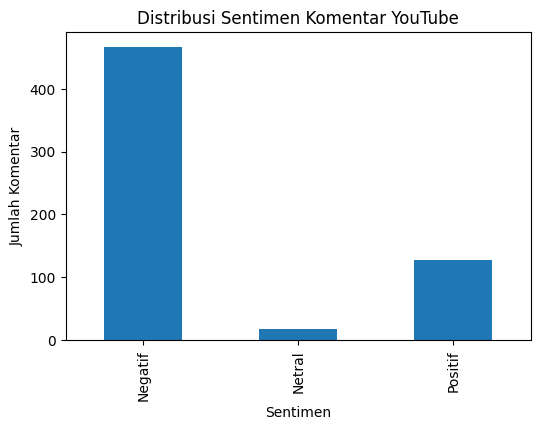

In [ ]:
# 6) Visualisasi Distribusi
ax = df["sentiment"].value_counts().sort_index().plot(kind="bar")
ax.set_title("Distribusi Sentimen Komentar YouTube")
ax.set_xlabel("Sentimen")
ax.set_ylabel("Jumlah Komentar")
plt.show()

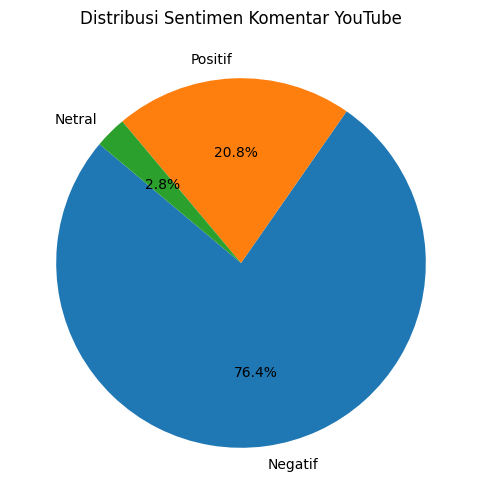

In [ ]:
import matplotlib.pyplot as plt

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(
    sentiment_summary['Jumlah'],
    labels=sentiment_summary.index,
    autopct='%1.1f%%',
    startangle=140
)
plt.title("Distribusi Sentimen Komentar YouTube")
plt.show()

In [ ]:
import replicate
from google.colab import userdata

api_token = userdata.get('api_token')
REPLICATE_API_TOKEN = api_token
client = replicate.Client(api_token=REPLICATE_API_TOKEN)

# Gabungkan komentar (misal maksimal 200 untuk ringkas)
all_comments = " ".join(df['text'].astype(str).tolist()[:200])

prompt = f"""
Tolong buat ringkasan dalam bahasa Indonesia berdasarkan komentar berikut.
Fokus pada tren utama dari sentimen positif, negatif, dan netral.
Jelaskan secara singkat dan jelas.
Komentar:
{all_comments}
"""

output = client.run(
    "ibm-granite/granite-3.3-8b-instruct",
    input={"prompt": prompt, "max_new_tokens": 300}
)

summary = "".join(output)

print("\n=== Ringkasan Otomatis ===\n")
print(summary)


=== Ringkasan Otomatis ===

**Ringkasan Sentimen Komentar:**

1. **Positif:**
   - Ada yang mengakui kelebihan AI sebagai alat bantu dalam proses kreatif.
   - Ada yang senang dengan hasil yang dihasilkan AI, terutama dalam konteks seni dan animasi.
   - Ada yang mengakui potensi AI dalam mempermudah pekerjaan, misalnya dalam pengembangan desain dan produk.

2. **Negatif:**
   - Banyak yang marah dan kecewa terhadap penggunaan AI untuk mengganti karya seniman tanpa hak cipta.
   - Kritik terhadap etika penggunaan AI, khususnya dalam mengambil sumber daya seni tanpa izin.
   - Kekecewaan terhadap kemungkinan AI menggantikan pekerjaan kreatif manusia.
   - Kritikan terhadap komersialisasi hasil AI tanpa memberikan hak kepada pembuat asli.

3. **Netral/Informasi:**
   - Diskusi tentang hak cipta dan regulasi AI dalam konteks seni dan seni animasi.
   - Pertanyaan tentang kesadaran masyarakat terhadap implikasi teknologi AI terhadap industri kreatif.
   - Ukuran potensi dan batasan AI dal

In [ ]:
df.to_csv("hasil_sentiment_final.csv", index=False)

In [ ]:
from google.colab import files
files.download("hasil_sentiment_final.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
with open("sentiment_summary_text.txt", "w", encoding="utf-8") as f:
    f.write(summary)

files.download("sentiment_summary_text.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>